# Install (restart runtime), import, and download

In [ ]:
# !python -m pip install --upgrade pip
# !pip install mindscope_utilities --upgrade

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn as skl
from sklearn.datasets import load_boston
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge, Lasso, LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.base import clone
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import random
import warnings
import time
from scipy.signal import savgol_filter

# import mindscope_utilities
# import mindscope_utilities.visual_behavior_ophys as ophys

# from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# data_storage_directory = "/temp" # Note: this path must exist on your local drive
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)
# session_table = cache.get_ophys_session_table()
# experiment_table = cache.get_ophys_experiment_table()
# session_table.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load novel passive session csv
 passive novel session, excitatory cells, mesoscope across area and layer -> feature matrix & output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/novel_passive_session_990464099_excitatory.csv')
adp_trial = all[all.repeat_number.notnull()]

neuron_ids = filter(lambda str: str.isnumeric(), adp_trial.columns.to_list())
neuron_ids = [neuron for neuron in neuron_ids]
features = adp_trial[neuron_ids]

# Linear Decoder
## data prep

In [ ]:
full_X = features
full_y = adp_trial.image_index

unadapted_X = features[adp_trial.repeat_number == 0]
unadapted_y = adp_trial[adp_trial.repeat_number == 0].image_index

adapted_X = features[adp_trial.repeat_number == 1]
adapted_y = adp_trial[adp_trial.repeat_number == 1].image_index

n_un = len(unadapted_y)
n_ad = len(adapted_y)
assert n_ad < n_un
print([full_X.shape, full_y.shape, unadapted_X.shape, unadapted_y.shape, adapted_X.shape, adapted_y.shape])

[(699, 477), (699,), (356, 477), (356,), (343, 477), (343,)]


In [ ]:
adapted_X_n = adapted_X.reset_index()
adapted_y_n = adapted_y.reset_index()

balance = np.array([0,100])
samplesArray = unadapted_X.index.to_numpy()
while (balance.max() - balance.min() > 4):
  np.random.shuffle(samplesArray); np.random.shuffle(samplesArray); np.random.shuffle(samplesArray)
  unadapted_X_n = unadapted_X.loc[samplesArray[:n_ad]].reset_index()
  unadapted_y_n = unadapted_y.loc[samplesArray[:n_ad]].reset_index()
  balance = unadapted_y_n.image_index.value_counts().to_numpy()

balance = np.array([0,100]); balance2 = balance
samplesArray = full_X.index.to_numpy()
while (balance.max() - balance.min() > 4) or (balance2.max() - balance2.min() > 8):
  np.random.shuffle(samplesArray); np.random.shuffle(samplesArray); np.random.shuffle(samplesArray)
  full_X_n = full_X.loc[samplesArray[:n_ad]].reset_index()
  full_y_n = full_y.loc[samplesArray[:n_ad]].reset_index()
  balance = full_y_n.image_index.value_counts().to_numpy()
  balance2 = adp_trial.loc[samplesArray[:n_ad]].repeat_number.value_counts()
  
print(unadapted_y_n.image_index.value_counts())
print(full_y_n.image_index.value_counts())
print(adp_trial.loc[samplesArray[:n_ad]].repeat_number.value_counts())

4    45
5    44
6    43
2    43
1    43
7    42
0    42
3    41
Name: image_index, dtype: int64
7    45
4    44
1    44
0    43
6    42
5    42
2    42
3    41
Name: image_index, dtype: int64
1.0    173
0.0    170
Name: repeat_number, dtype: int64


## all -> all
SVM: SVC(C=1.0, kernel='rbf'), shuffle & split -> leave one out   
OR gridsearch hyperparam

In [ ]:
# all -> all
X = full_X_n
y = full_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

full_acc = []
y_test_seq = []; y_pred_seq = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.loc[train_index].values[:,1:], X.loc[test_index].values[:,1:]
    y_train, y_test = y.loc[train_index].values[:,1], y.loc[test_index].values[:,1]

    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_seq.append(y_pred); y_test_seq.append(y_test)
    acc = accuracy_score(y_test, y_pred)
    full_acc.append(acc)

np.mean(full_acc), np.std(full_acc)

(0.7259475218658892, 0.4460355561641511)

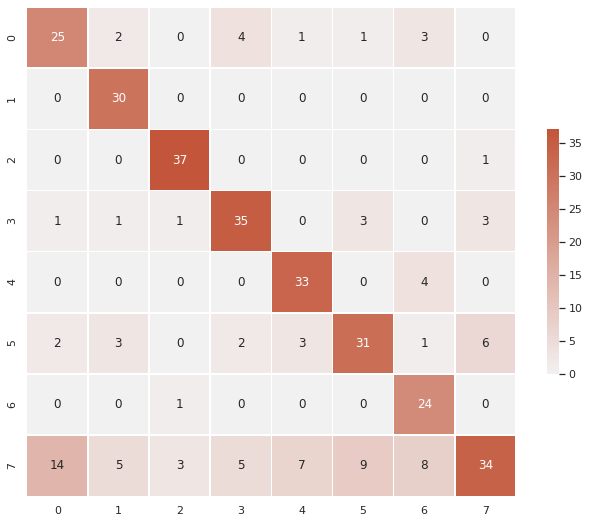

In [ ]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

con = pd.DataFrame(confusion_matrix(y_pred_seq, y_test_seq))
# con
sns.heatmap(con, annot=True, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### grid all->all
hyperparam gridsearch

In [ ]:
X_training = full_X_n.values[:,1:]
y_training = full_y_n.values[:,1]

# Grid Search testing
param_grid = { 
                'loss' : ('hinge', # (soft-margin) linear SVM
                          'modified_huber', # is another smooth loss that brings tolerance to outliers as well as probability estimates
                          'log', # logistic regression, a probabilistic classifier
                          'squared_hinge', # is like hinge but is quadratically penalized
                          'perceptron'), # is the linear loss used by the perceptron algorithm

                'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10], 
                          #  1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 

                'penalty' : ['elasticnet'],

                'l1_ratio' : np.round(np.arange(1, -.1, -.2), 3)
                          # np.round(np.arange(1, -.1, -.1), 3)
             }

nFold = 5
clf_full = GridSearchCV(SGDClassifier(max_iter=10000), param_grid, cv=nFold, verbose=1)

# Run Model
total_time = time.time()
clf_full.fit(X_training, y_training)
print('Done!')
print("Total Time: ", np.round((time.time() - total_time), 3), 's' )

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

Done!
Total Time:  1341.59 s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 22.4min finished


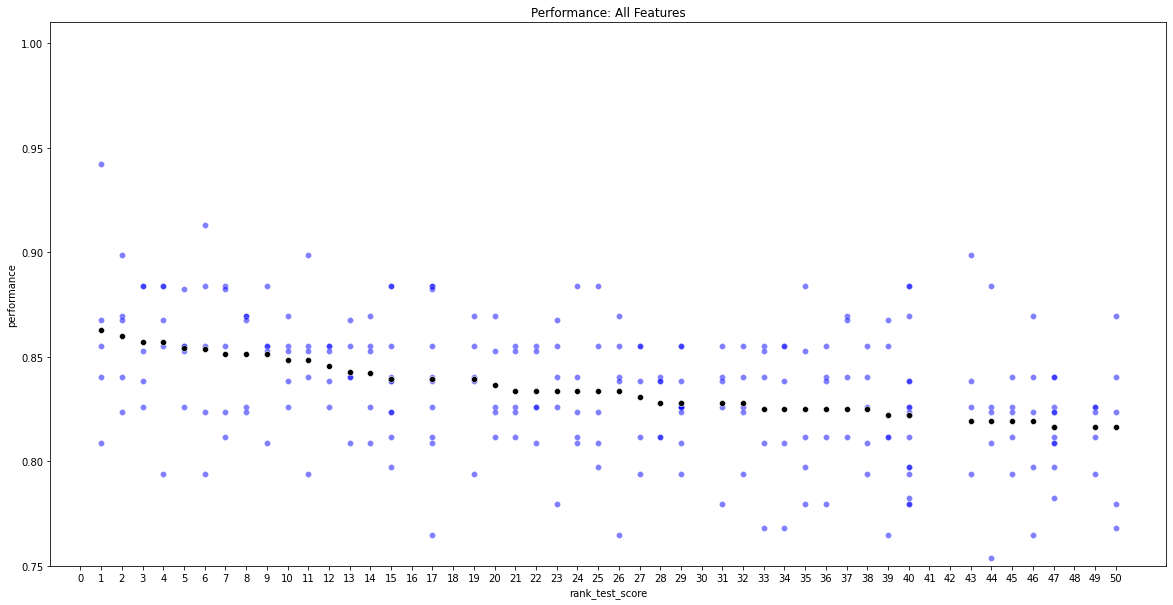

In [ ]:
cv_results = pd.DataFrame(clf_full.cv_results_)
nbest = 50
best_full = cv_results[cv_results['rank_test_score'] < nbest+1]
best_full

f, axes = plt.subplots(1,1, figsize=(20, 10))
for i in np.arange(nFold):
 col = 'split' + str(i) + '_test_score'
 sns.scatterplot(data=best_full, y=col, x='rank_test_score', ax=axes, color='b', alpha=.5)

fig = sns.scatterplot(data=best_full, y='mean_test_score', x='rank_test_score', ax=axes, color='k')
axes.set_xticks(np.arange(nbest+1))
axes.set_ylim([0.75, 1.01])
axes.set_yticks(np.arange(0.75, 1.01, 0.05))
axes.set_title('Performance: All Features')
axes.set_ylabel('performance');
# f.savefig('Classification - Validation Performance - All Features.jpg')

In [ ]:
best_full.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
71,0.113654,0.013047,0.000859,0.000114,0.01,0.6,modified_huber,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.6, 'loss': 'modi...",0.855072,0.840580,0.942029,0.867647,0.808824,0.862830,0.044199,1
85,0.133433,0.022877,0.000797,0.000124,0.01,0,hinge,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.0, 'loss': 'hing...",0.840580,0.869565,0.898551,0.867647,0.823529,0.859974,0.025859,2
47,0.149435,0.018908,0.001343,0.001023,0.001,0.4,log,elasticnet,"{'alpha': 0.001, 'l1_ratio': 0.4, 'loss': 'log...",0.826087,0.884058,0.884058,0.852941,0.838235,0.857076,0.023615,3
57,0.107400,0.020591,0.000857,0.000114,0.001,0,log,elasticnet,"{'alpha': 0.001, 'l1_ratio': 0.0, 'loss': 'log...",0.884058,0.855072,0.884058,0.867647,0.794118,0.856991,0.033273,4
45,0.123307,0.025535,0.000881,0.000173,0.001,0.4,hinge,elasticnet,"{'alpha': 0.001, 'l1_ratio': 0.4, 'loss': 'hin...",0.826087,0.855072,0.855072,0.882353,0.852941,0.854305,0.017810,5


## un -> un / all

In [ ]:
# un -> un
X = unadapted_X_n
y = unadapted_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

un_acc = []
y_test_seq = []; y_pred_seq = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.loc[train_index].values[:,1:], X.loc[test_index].values[:,1:]
    y_train, y_test = y.loc[train_index].values[:,1], y.loc[test_index].values[:,1]

    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_seq.append(y_pred); y_test_seq.append(y_test)
    acc = accuracy_score(y_test, y_pred)
    un_acc.append(acc)

np.mean(un_acc), np.std(un_acc)

(0.10204081632653061, 0.30270197906512913)

0.4502923976608187


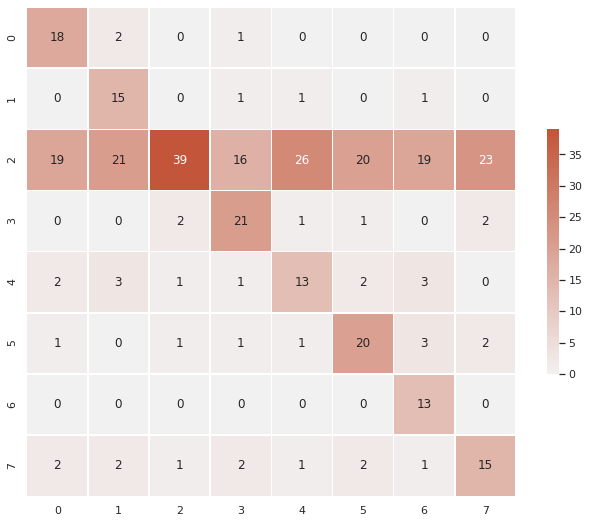

In [ ]:
y_pred_train = model.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

con = pd.DataFrame(confusion_matrix(y_pred_train, y_train))
# con
sns.heatmap(con, annot=True, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

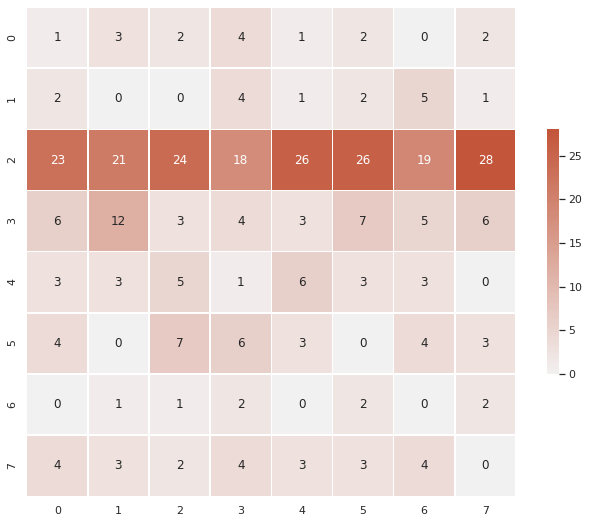

In [ ]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

con = pd.DataFrame(confusion_matrix(y_pred_seq, y_test_seq))
# con
sns.heatmap(con, annot=True, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# un -> all
X = full_X_n
y = full_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

unall_acc = []
y_test_seq = []; y_pred_seq = []
for train_index, test_index in loo.split(X):
    X_train = unadapted_X_n.values[:,1:] # train w/ unadapted
    y_train = unadapted_y_n.values[:,1]
    X_test = X.loc[test_index].values[:,1:] # test w/ full
    y_test = y.loc[test_index].values[:,1]
    
    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_seq.append(y_pred); y_test_seq.append(y_test)
    acc = accuracy_score(y_test, y_pred)
    unall_acc.append(acc)

np.mean(unall_acc), np.std(unall_acc)

(0.07871720116618076, 0.26929686854240203)

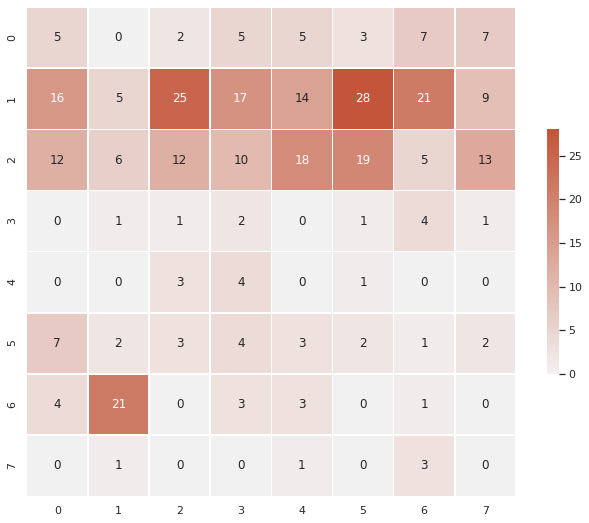

In [ ]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

con = pd.DataFrame(confusion_matrix(y_pred_seq, y_test_seq))
# con
sns.heatmap(con, annot=True, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### grid un->un

In [ ]:
# @ignore_warnings(category=ConvergenceWarning)

X_training = unadapted_X_n.values[:,1:]
y_training = unadapted_y_n.values[:,1]

# Grid Search testing
param_grid = { 
                'loss' : ('hinge', # (soft-margin) linear SVM
                          'modified_huber', # is another smooth loss that brings tolerance to outliers as well as probability estimates
                          'log', # logistic regression, a probabilistic classifier
                          'squared_hinge', # is like hinge but is quadratically penalized
                          'perceptron'), # is the linear loss used by the perceptron algorithm

                'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10], 
                          #  1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 

                'penalty' : ['elasticnet'],

                'l1_ratio' : np.round(np.arange(1, -.1, -.2), 3)
                          # np.round(np.arange(1, -.1, -.1), 3)
             }

nFold = 5
clf_un = GridSearchCV(SGDClassifier(max_iter=10000), param_grid, cv=nFold, verbose=1)

# Run Model
total_time = time.time()
clf_un.fit(X_training, y_training)
print('Done!')
print("Total Time: ", np.round((time.time() - total_time), 3), 's' )

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

Done!
Total Time:  1963.758 s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 32.7min finished


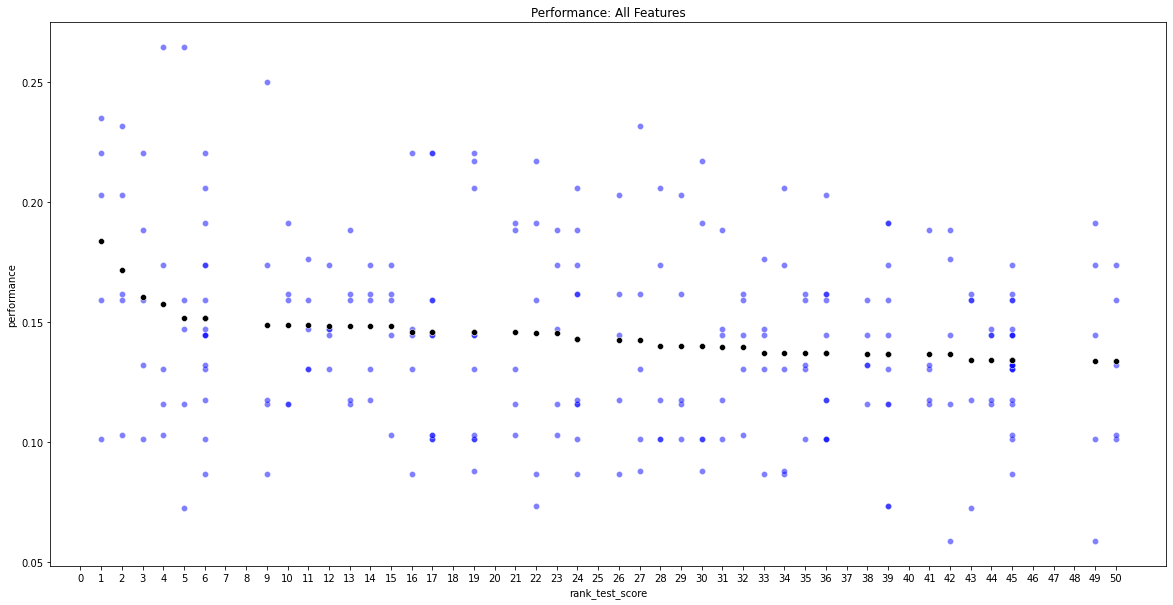

In [ ]:
cv_results = pd.DataFrame(clf_un.cv_results_)
nbest = 50
best_un = cv_results[cv_results['rank_test_score'] < nbest+1]
best_un

f, axes = plt.subplots(1,1, figsize=(20, 10))
for i in np.arange(nFold):
 col = 'split' + str(i) + '_test_score'
 sns.scatterplot(data=best_un, y=col, x='rank_test_score', ax=axes, color='b', alpha=.5)

fig = sns.scatterplot(data=best_un, y='mean_test_score', x='rank_test_score', ax=axes, color='k')
# axes.set_ylim([0.75, 1])
axes.set_xticks(np.arange(nbest+1))
# axes.set_yticks(np.arange(0.75, 1, 0.05))
axes.set_title('Performance: All Features')
axes.set_ylabel('performance');
# f.savefig('Classification - Validation Performance - All Features.jpg')

In [ ]:
best_un.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
84,0.126852,0.024467,0.000804,0.000131,0.01,0.2,perceptron,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.2, 'loss': 'perc...",0.159420,0.101449,0.202899,0.235294,0.220588,0.183930,0.048468,1
4,0.143904,0.020015,0.001322,0.000265,0.0001,1,perceptron,elasticnet,"{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'pe...",0.231884,0.159420,0.202899,0.161765,0.102941,0.171782,0.043755,2
81,0.193435,0.020923,0.000816,0.000120,0.01,0.2,modified_huber,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.2, 'loss': 'modi...",0.188406,0.101449,0.159420,0.220588,0.132353,0.160443,0.041641,3
82,0.215581,0.017458,0.000809,0.000113,0.01,0.2,log,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.2, 'loss': 'log'...",0.173913,0.130435,0.115942,0.264706,0.102941,0.157587,0.058649,4
113,6.161553,3.108634,0.001979,0.000660,0.1,0.2,squared_hinge,elasticnet,"{'alpha': 0.1, 'l1_ratio': 0.2, 'loss': 'squar...",0.159420,0.115942,0.072464,0.264706,0.147059,0.151918,0.063888,5


## ad -> ad / all

In [ ]:
# ad -> ad
X = adapted_X_n
y = adapted_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

ad_acc = []
y_test_seq = []; y_pred_seq = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.loc[train_index].values[:,1:], X.loc[test_index].values[:,1:]
    y_train, y_test = y.loc[train_index].values[:,1], y.loc[test_index].values[:,1]

    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_seq.append(y_pred); y_test_seq.append(y_test)
    acc = accuracy_score(y_test, y_pred)
    ad_acc.append(acc)

np.mean(ad_acc), np.std(ad_acc)

(0.6064139941690962, 0.4885448411814207)

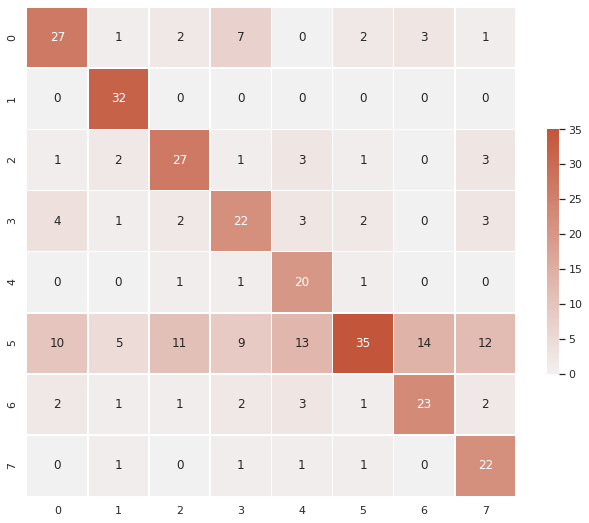

In [ ]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

con = pd.DataFrame(confusion_matrix(y_pred_seq, y_test_seq))
# con
sns.heatmap(con, annot=True, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# ad -> all
X = full_X_n
y = full_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

adall_acc = []
y_test_seq = []; y_pred_seq = []
for train_index, test_index in loo.split(X):
    X_train = adapted_X_n.values[:,1:] # train w/ adapted
    y_train = adapted_y_n.values[:,1]
    X_test = X.loc[test_index].values[:,1:] # test w/ full
    y_test = y.loc[test_index].values[:,1]
    
    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_seq.append(y_pred); y_test_seq.append(y_test)
    acc = accuracy_score(y_test, y_pred)
    adall_acc.append(acc)

np.mean(adall_acc), np.std(adall_acc)

(0.7959183673469388, 0.40302893179860205)

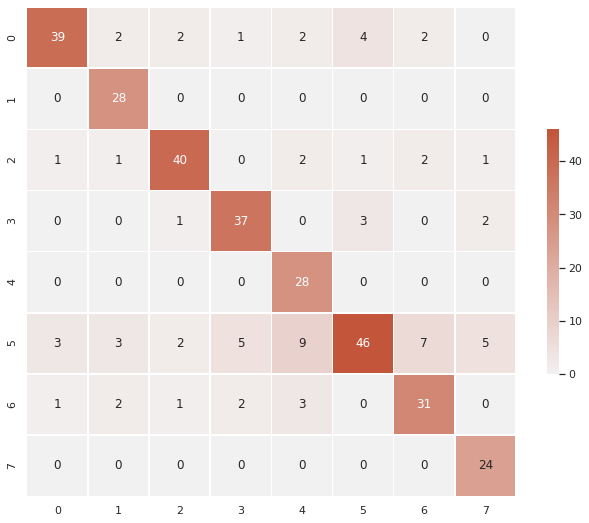

In [ ]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

con = pd.DataFrame(confusion_matrix(y_pred_seq, y_test_seq))
# con
sns.heatmap(con, annot=True, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### grid ad->ad

In [ ]:
# @ignore_warnings(category=ConvergenceWarning)

X_training = adapted_X_n.values[:,1:]
y_training = adapted_y_n.values[:,1]

# Grid Search testing
param_grid = { 
                'loss' : ('hinge', # (soft-margin) linear SVM
                          'modified_huber', # is another smooth loss that brings tolerance to outliers as well as probability estimates
                          'log', # logistic regression, a probabilistic classifier
                          'squared_hinge', # is like hinge but is quadratically penalized
                          'perceptron'), # is the linear loss used by the perceptron algorithm

                'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10], 
                          #  1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 

                'penalty' : ['elasticnet'],

                'l1_ratio' : np.round(np.arange(1, -.1, -.2), 3)
                          # np.round(np.arange(1, -.1, -.1), 3)
             }

nFold = 5
clf_ad = GridSearchCV(SGDClassifier(max_iter=10000), param_grid, cv=nFold, verbose=1)

# Run Model
total_time = time.time()
clf_ad.fit(X_training, y_training)
print('Done!')
print("Total Time: ", np.round((time.time() - total_time), 3), 's' )

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

Done!
Total Time:  1197.927 s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 20.0min finished


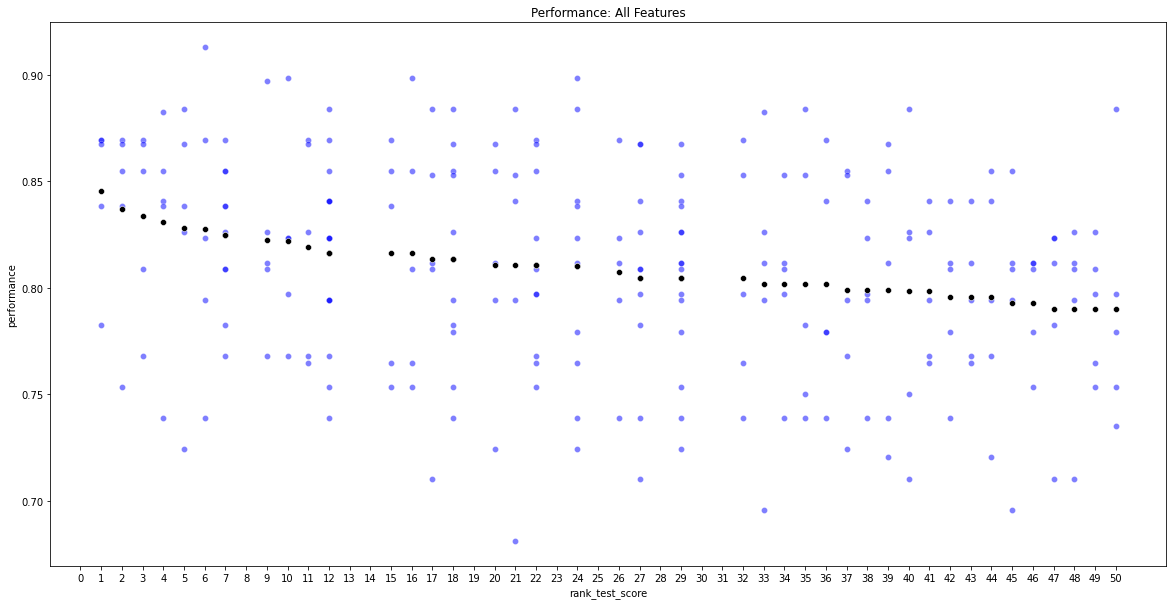

In [ ]:
cv_results = pd.DataFrame(clf_ad.cv_results_)
nbest = 50
best_ad = cv_results[cv_results['rank_test_score'] < nbest+1]
best_ad

f, axes = plt.subplots(1,1, figsize=(20, 10))
for i in np.arange(nFold):
 col = 'split' + str(i) + '_test_score'
 sns.scatterplot(data=best_ad, y=col, x='rank_test_score', ax=axes, color='b', alpha=.5)

fig = sns.scatterplot(data=best_ad, y='mean_test_score', x='rank_test_score', ax=axes, color='k')
# axes.set_ylim([0.75, 1])
axes.set_xticks(np.arange(nbest+1))
# axes.set_yticks(np.arange(0.75, 1, 0.05))
axes.set_title('Performance: All Features')
axes.set_ylabel('performance');
# f.savefig('Classification - Validation Performance - All Features.jpg')

In [ ]:
best_ad.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,0.120760,0.019721,0.000719,0.000117,0.01,0,hinge,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.0, 'loss': 'hing...",0.869565,0.869565,0.782609,0.867647,0.838235,0.845524,0.033636,1
52,0.142741,0.020797,0.000798,0.000146,0.001,0.2,log,elasticnet,"{'alpha': 0.001, 'l1_ratio': 0.2, 'loss': 'log...",0.869565,0.855072,0.753623,0.838235,0.867647,0.836829,0.043080,2
86,0.081759,0.011596,0.000736,0.000106,0.01,0,modified_huber,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.0, 'loss': 'modi...",0.869565,0.855072,0.768116,0.867647,0.808824,0.833845,0.039536,3
80,0.118740,0.018537,0.000860,0.000107,0.01,0.2,hinge,elasticnet,"{'alpha': 0.01, 'l1_ratio': 0.2, 'loss': 'hing...",0.855072,0.840580,0.739130,0.882353,0.838235,0.831074,0.048581,4
116,0.096135,0.013558,0.001241,0.000978,0.1,0,modified_huber,elasticnet,"{'alpha': 0.1, 'l1_ratio': 0.0, 'loss': 'modif...",0.884058,0.826087,0.724638,0.867647,0.838235,0.828133,0.055689,5


## un -> ad

In [ ]:
# un -> ad
X = adapted_X_n
y = adapted_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

unad_acc = []
for train_index, test_index in loo.split(X):
    X_train = unadapted_X_n.values[:,1:] # train w/ unadapted
    y_train = unadapted_y_n.values[:,1]
    X_test = X.loc[test_index].values[:,1:] # test w/ adapted
    y_test = y.loc[test_index].values[:,1]
    
    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    unad_acc.append(acc)

np.mean(unad_acc), np.std(unad_acc)

(0.09912536443148688, 0.2988302637916913)

### grid un -> test w ad

In [ ]:
best_un.sort_values(by=['mean_test_score'], ascending=False).head(3).params.values

array([{'alpha': 0.1, 'l1_ratio': 0.2, 'loss': 'squared_hinge', 'penalty': 'elasticnet'},
       {'alpha': 0.01, 'l1_ratio': 0.6, 'loss': 'log', 'penalty': 'elasticnet'},
       {'alpha': 1, 'l1_ratio': 0.4, 'loss': 'squared_hinge', 'penalty': 'elasticnet'}],
      dtype=object)

In [ ]:
X_training = unadapted_X_n.values[:,1:]
y_training = unadapted_y_n.values[:,1]
X_test = adapted_X_n.values[:,1:]
y_test = adapted_y_n.values[:,1]

unad_acc_grid = []
for i in np.arange(10):
  clf_un.best_estimator_.fit(X_training, y_training)
  y_pred = clf_un.best_estimator_.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  unad_acc_grid.append(acc)
np.mean(unad_acc_grid), np.std(unad_acc_grid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

(0.12419825072886297, 0.01764751714334875)

### grid un -> test w all [bug]
bug to fix: train w 4/5 un & test w 1/5 un + 5/5 ad

In [ ]:
full_sort = adp_trial.sort_values(by='repeat_number')
features_sort = full_sort[neuron_ids]

un_X = features_sort[adp_trial.repeat_number == 0]
un_y = adp_trial[adp_trial.repeat_number == 0].image_index
ad_X = features_sort[adp_trial.repeat_number == 1]
ad_y = adp_trial[adp_trial.repeat_number == 1].image_index

samplesArray = un_X.index.to_numpy()
np.random.shuffle(samplesArray); np.random.shuffle(samplesArray); np.random.shuffle(samplesArray)
cut_id = 4*len(samplesArray)//5
un_X_more = un_X.loc[samplesArray[:cut_id]].reset_index()
un_y_more = un_y.loc[samplesArray[:cut_id]].reset_index()
un_X_less = un_X.loc[samplesArray[cut_id:]].reset_index()
un_y_less = un_y.loc[samplesArray[cut_id:]].reset_index()
len(un_y_less), len(un_y_more), len(un_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(72, 284, 356)

In [ ]:
np.concatenate((un_y_more.values[:,1:], ad_y.values), axis=0).shape

ValueError: ignored

In [ ]:
X_training = np.concatenate((un_X_more.values[:,1:], ad_X.values), axis=0)
y_training = unadapted_y_n.values[:,1]
X_test = full_X_n.values[:,1:]
y_test = full_y_n.values[:,1]

unall_acc_grid = []
for i in np.arange(10):
  clf_un.best_estimator_.fit(X_training, y_training)
  y_pred = clf_un.best_estimator_.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  unall_acc_grid.append(acc)
np.mean(unall_acc_grid), np.std(unall_acc_grid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

(0.12361516034985423, 0.014877377052096876)

## ad -> un

In [ ]:
# ad -> un
X = unadapted_X_n
y = unadapted_y_n
loo = LeaveOneOut()
loo.get_n_splits(X)

adun_acc = []
for train_index, test_index in loo.split(X):
    X_train = adapted_X_n.values[:,1:] # train w/ adapted
    y_train = adapted_y_n.values[:,1]
    X_test = X.loc[test_index].values[:,1:] # test w/ unadapted
    y_test = y.loc[test_index].values[:,1]
    
    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    adun_acc.append(acc)

np.mean(adun_acc), np.std(adun_acc)

(0.10495626822157435, 0.306497063579042)

### grid ad -> test w un

In [ ]:
X_training = adapted_X_n.values[:,1:]
y_training = adapted_y_n.values[:,1]
X_test = unadapted_X_n.values[:,1:]
y_test = unadapted_y_n.values[:,1]

adun_acc_grid = []
for i in np.arange(10):
  clf_ad.best_estimator_.fit(X_training, y_training)
  y_pred = clf_ad.best_estimator_.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  adun_acc_grid.append(acc)
np.mean(adun_acc_grid), np.std(adun_acc_grid)

(0.12332361516034987, 0.003461907314005227)

### grid ad -> test w all [bug]

In [ ]:
X_training = adapted_X_n.values[:,1:]
y_training = adapted_y_n.values[:,1]
X_test = full_X_n.values[:,1:]
y_test = full_y_n.values[:,1]

adall_acc_grid = []
for i in np.arange(10):
  clf_ad.best_estimator_.fit(X_training, y_training)
  y_pred = clf_ad.best_estimator_.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  adall_acc_grid.append(acc)
np.mean(adall_acc_grid), np.std(adall_acc_grid)

(0.9524781341107872, 0.004334130830122019)

## compare performance

In [ ]:
print([np.mean(ad_acc), np.mean(adun_acc), np.mean(adall_acc), np.mean(full_acc)])
print([np.mean(un_acc), np.mean(unad_acc), np.mean(unall_acc)])

[0.6064139941690962, 0.10495626822157435, 0.7959183673469388, 0.6909620991253644]
[0.08163265306122448, 0.09912536443148688, 0.07871720116618076]


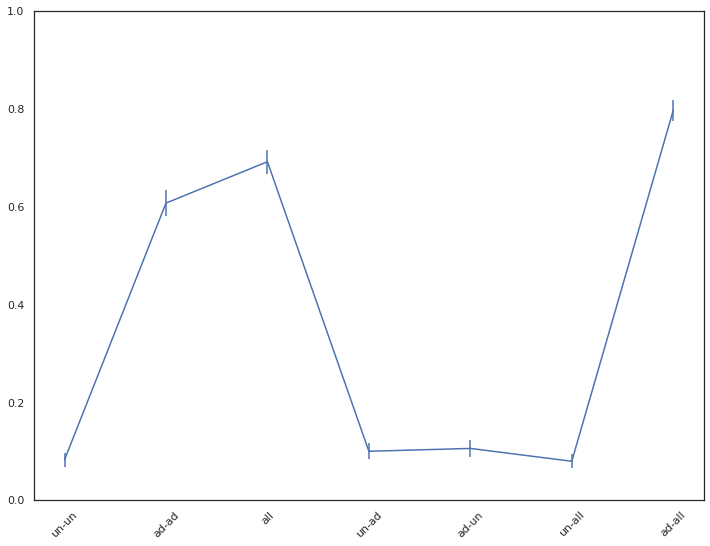

In [ ]:
# plot mean +- sem of accuracy
x = np.arange(7)
y = [np.mean(un_acc), np.mean(ad_acc), np.mean(full_acc), 
     np.mean(unad_acc), np.mean(adun_acc), 
     np.mean(unall_acc), np.mean(adall_acc)]
yerr = [np.std(un_acc), np.std(ad_acc), np.std(full_acc), 
        np.std(unad_acc), np.std(adun_acc), 
        np.std(unall_acc), np.std(adall_acc)] / np.sqrt(len(un_acc))

plt.figure(figsize=(12,9))
plt.errorbar(x, y, yerr=yerr)
# plt.hlines(y=0.125, xmin=0, xmax=4, linestyles='--', colors='r')
# plt.hlines(y=1, xmin=0, xmax=4, linestyles='--', colors='g')
labels = ['un-un', 'ad-ad', 'all', 'un-ad', 'ad-un', 'un-all', 'ad-all'];
plt.xticks(x, labels, rotation=45);
plt.ylim(-0,1);

[0.1428559249786871, 0.8350298380221653, 0.8821142369991474, 0.12419825072886297, 0.12361516034985423, 0.12332361516034987, 0.9524781341107872]
[0.0021487  0.00239572 0.00157882 0.00789221 0.00665337 0.00154821
 0.00193828]


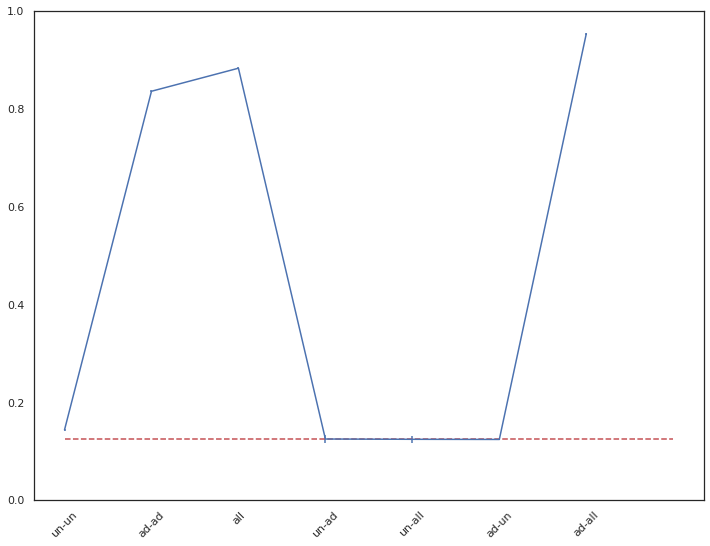

In [ ]:
n_model = 5
full_acc_grid = best_full.sort_values(by=['mean_test_score'], ascending=False).head(n_model).mean_test_score.values
un_acc_grid = best_un.sort_values(by=['mean_test_score'], ascending=False).head(n_model).mean_test_score.values
ad_acc_grid = best_ad.sort_values(by=['mean_test_score'], ascending=False).head(n_model).mean_test_score.values

# plot mean +- sem of accuracy
x = np.arange(7)
y = [un_acc_grid.mean(), ad_acc_grid.mean(), full_acc_grid.mean(), 
     np.mean(unad_acc_grid), np.mean(unall_acc_grid), np.mean(adun_acc_grid), np.mean(adall_acc_grid)]
yerr = [un_acc_grid.std(), ad_acc_grid.std(), full_acc_grid.std(), 
        np.std(unad_acc_grid), np.std(unall_acc_grid), np.std(adun_acc_grid), np.std(adall_acc_grid)] / np.sqrt(len(un_acc_grid))
print(y)
print(yerr)

plt.figure(figsize=(12,9))
plt.errorbar(x, y, yerr=yerr)
plt.hlines(y=0.125, xmin=0, xmax=7, linestyles='--', colors='r')
# plt.hlines(y=1, xmin=0, xmax=4, linestyles='--', colors='g')
labels = ['un-un', 'ad-ad', 'all', 'un-ad', 'un-all', 'ad-un', 'ad-all'];
plt.xticks(x, labels, rotation=45);
plt.ylim(-0,1);

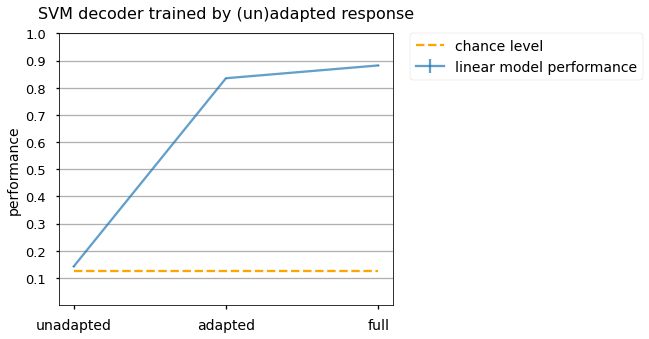

In [ ]:
x = np.arange(3)
y = [0.1428559249786871, 0.8350298380221653, 0.8821142369991474] #, 0.12419825072886297, 0.12332361516034987]
yerr = [0.0021487, 0.00239572, 0.00157882] #, 0.00789221, 0.00154821]

plt.style.use('seaborn-talk')
plt.figure(figsize=(6,5))
plt.errorbar(x, y, yerr=yerr, alpha=0.7, label='linear model performance')
plt.hlines(y=0.125, xmin=0, xmax=2, linestyles='--', colors='orange', label='chance level')
plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(['chance level', 'linear model performance'], loc='center right', fontsize=14)
figtitle = 'SVM decoder trained by (un)adapted response'
plt.title(figtitle, fontsize=16, pad=15)

labels = ['unadapted', 'adapted', 'full'] #, 'U-A', 'A-U'];
plt.xticks(x, labels, rotation=0, fontsize=14);
plt.ylim(-0,1);
plt.yticks(np.arange(0.1,1.01,0.1))
plt.grid(axis = 'y')
plt.ylabel("performance", fontsize=14);

# plt.savefig(figtitle + '.pdf', format='pdf')
# from google.colab import files
# files.download(figtitle + '.pdf')

## save / load lin decoder grid result
saved pickle file is result of grid search, max_iter=1000

In [ ]:
# import pickle
# file_name = 'linear_decoder_grid.pckl'
# f = open(file_name, 'wb')
# pickle.dump([clf_full, best_full, clf_ad, best_ad, clf_un, best_un], f)
# f.close()
# from google.colab import files
# files.download(file_name)

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/"
DATA_PATH = "/content/drive/MyDrive/"
file_name = 'linear_decoder_grid.pckl'

f = open(DATA_PATH + file_name,'rb')
clf_full, best_full, clf_ad, best_ad, clf_un, best_un = pickle.load(f)
f.close()
best_full.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.155362,0.019980,0.001003,0.000476,0.0001,1,log,elasticnet,"{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'lo...",0.898551,0.869565,0.884058,0.867647,0.808824,0.865729,0.030561,20
3,0.094610,0.020675,0.000774,0.000098,0.0001,1,squared_hinge,elasticnet,"{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'sq...",0.884058,0.855072,0.855072,0.852941,0.823529,0.854135,0.019159,30
4,0.090209,0.016432,0.001003,0.000394,0.0001,1,perceptron,elasticnet,"{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'pe...",0.840580,0.811594,0.898551,0.838235,0.808824,0.839557,0.032279,44
5,0.096890,0.019003,0.000860,0.000090,0.0001,0.8,hinge,elasticnet,"{'alpha': 0.0001, 'l1_ratio': 0.8, 'loss': 'hi...",0.884058,0.855072,0.869565,0.882353,0.838235,0.865857,0.017300,18
6,0.095106,0.017879,0.000806,0.000076,0.0001,0.8,modified_huber,elasticnet,"{'alpha': 0.0001, 'l1_ratio': 0.8, 'loss': 'mo...",0.884058,0.855072,0.884058,0.852941,0.794118,0.854049,0.032848,31


In [ ]:
print(best_full.head(1).params.values)

[{'alpha': 0.0001, 'l1_ratio': 1.0, 'loss': 'log', 'penalty': 'elasticnet'}]


# Selectivity hypothesis
Hypothesis: cells important to decode each image are still activated post adaptation, while unimportant cells are changed by adp

## cells' weight in decoder is correlated w adaptation magnitude 
adp_mag by cell  
ad->ad or all->all decoder weight  

In [ ]:
# adp_trial.drop(columns=["stimulus_presentations_id", "omitted", "is_change"], inplace=True)
temp2 = adp_trial.drop(columns=["stimulus_presentations_id", "omitted", "is_change"]).copy().groupby(by=["image_index", "repeat_number"]).mean()
# temp2

unadapted_resp = temp2.to_numpy().T[:, 0::2]
adapted_resp = temp2.to_numpy().T[:, 1::2]
adp_mag = (unadapted_resp - adapted_resp) / unadapted_resp

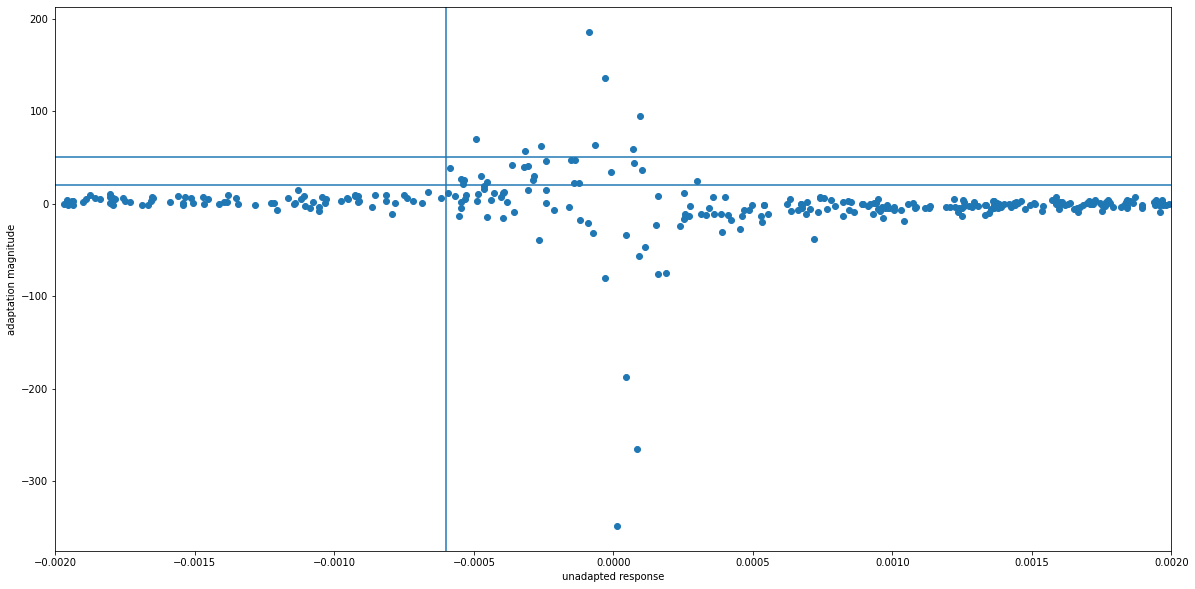

In [ ]:
plt.subplots(1,1, figsize=(20, 10))
plt.scatter(unadapted_resp, adp_mag)
plt.axhline(y=50); plt.axhline(y=20);
plt.axvline(x=-0.0006); # cutoff value for un_resp

plt.xlim(-0.002,0.002);
plt.ylabel("adaptation magnitude")
plt.xlabel("unadapted response");

In [ ]:
unadapted_resp = temp2.to_numpy().T[:, 0::2]
adapted_resp = temp2.to_numpy().T[:, 1::2]
adp_mag = (unadapted_resp - adapted_resp) / unadapted_resp

# adp_mag[np.abs(adp_mag) > 20] = np.nan
adp_mag[np.abs(adp_mag) > 20] = np.median(adp_mag[:])
# plt.hist(adp_mag);

### cells more varied by adaptation have smaller weight post adaptation
cells' np.abs(adp_mag) is more uncoupled from weight in adapted decoder

In [ ]:
full_weight = clf_full.best_estimator_.coef_.T
un_weight = clf_un.best_estimator_.coef_.T
ad_weight = clf_ad.best_estimator_.coef_.T

def get_corr(weight, adp_mag):
  n_img = 8; corr = []; control = []
  for i in np.arange(n_img):
    icorr = np.corrcoef(weight[:,i], np.abs(adp_mag[:,i]))
    icontrol = np.corrcoef(np.random.permutation(weight[:,i]), np.random.permutation(np.abs(adp_mag[:,i])))
    corr.append(icorr); control.append(icontrol)
  print(np.mean(corr), np.mean(control))
  # return np.mean(corr), np.mean(control)

get_corr(un_weight, adp_mag)
get_corr(ad_weight, adp_mag)
get_corr(full_weight, adp_mag)

0.5022422791332988 0.4966035639831111
0.4555493219427674 0.49843381853211427
0.43524795648406345 0.5015941693246552


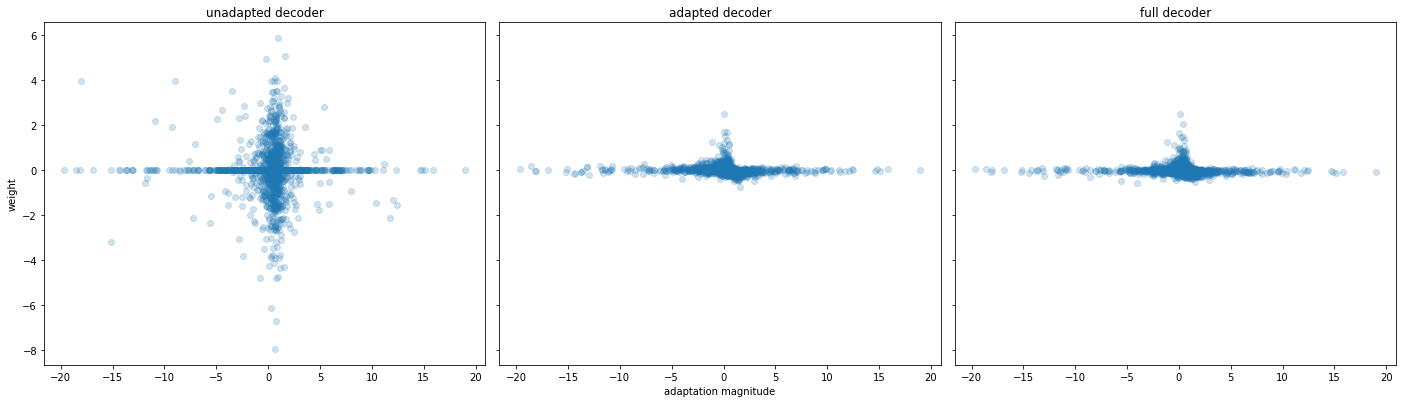

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6), sharex=True, sharey=True)

ax1.scatter(adp_mag[:], un_weight[:], alpha=0.2)
ax1.set_title("unadapted decoder")
ax2.scatter(adp_mag[:], ad_weight[:],alpha=0.2)
ax2.set_title("adapted decoder")
ax3.scatter(adp_mag[:], full_weight[:],alpha=0.2)
ax3.set_title("full decoder")
# plt.setp(ax1, xlim=(-1,2))

f.add_subplot(111, frameon=False); plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("weight")
plt.xlabel("adaptation magnitude");
# plt.title("cells more varied by adaptation have smaller weight in post-adaptation decoder");
plt.tight_layout()

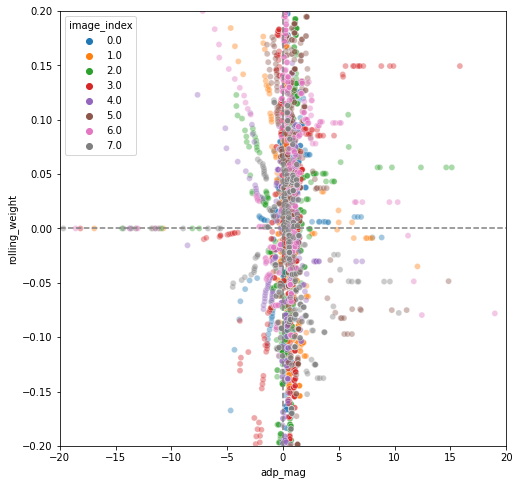

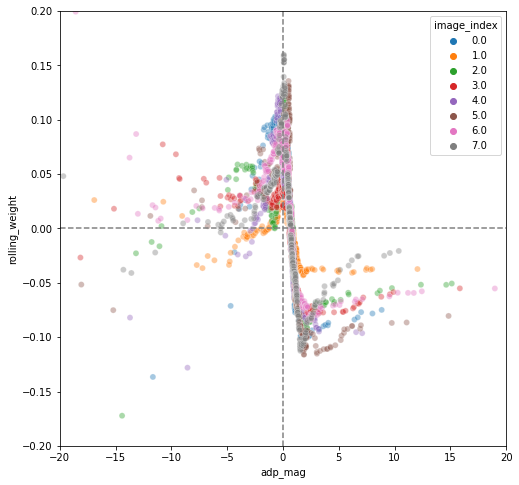

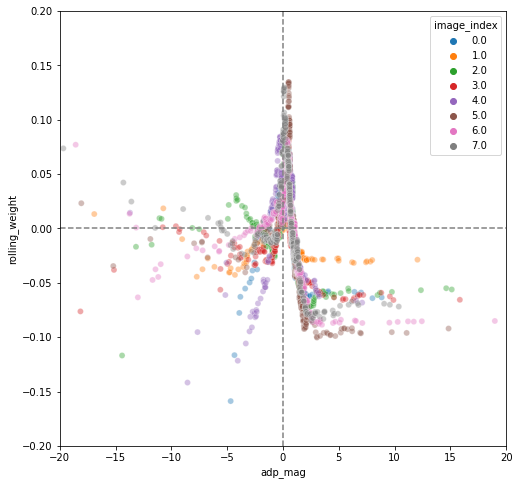

In [ ]:
# rolling mean of weight across adp_mag

image_index = np.ones_like(adp_mag)
for i in np.arange(8):
  image_index[:,i] = i * np.ones((len(neuron_ids),))

def plot_weight_across_adp(weight):
  weight_vs_adp = np.array([adp_mag.flatten('F'), weight.flatten('F'), image_index.flatten('F')]).T
  df = pd.DataFrame(weight_vs_adp, columns=["adp_mag", "weight", "image_index"])

  df_whole = pd.DataFrame()
  for i in np.arange(8):
    df_img = df[df.image_index == i].sort_values(by=['adp_mag'], ascending=True).copy()
    df_img['rolling_weight'] = df_img['weight'].rolling(50, min_periods=1).mean()
    df_whole = pd.concat([df_whole,df_img])

  df_whole['image_index'] = df_whole.image_index.astype('category')
  plt.subplots(figsize=(8, 8))
  sns.scatterplot(data=df_whole, x="adp_mag", y="rolling_weight", hue="image_index", alpha=0.4)
  plt.xlim(-20,20); 
  # plt.xlim(-1,1);

  # plt.ylim(-2,4);
  plt.ylim(-0.2,0.2);
  plt.axhline(y=0, linestyle='--', color='grey'); plt.axvline(x=0, linestyle='--', color='grey');
  
  return df_whole


# f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15, 10), sharex=True, sharey=True)
# ax1 = plot_weight_across_adp(un_weight)
df_whole_un = plot_weight_across_adp(un_weight)
df_whole_ad = plot_weight_across_adp(ad_weight)
df_whole_full = plot_weight_across_adp(full_weight)

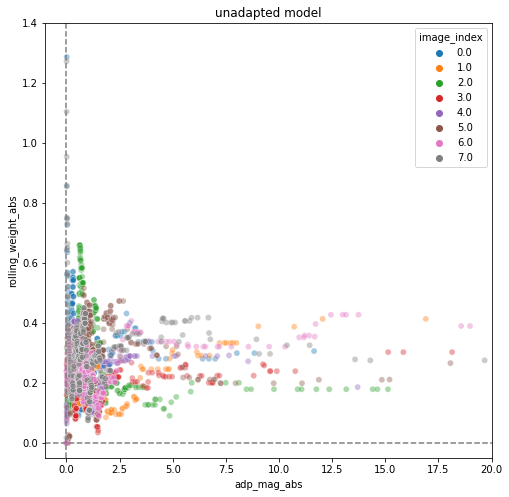

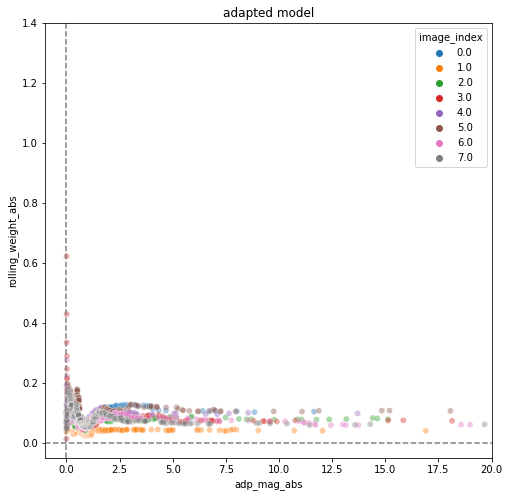

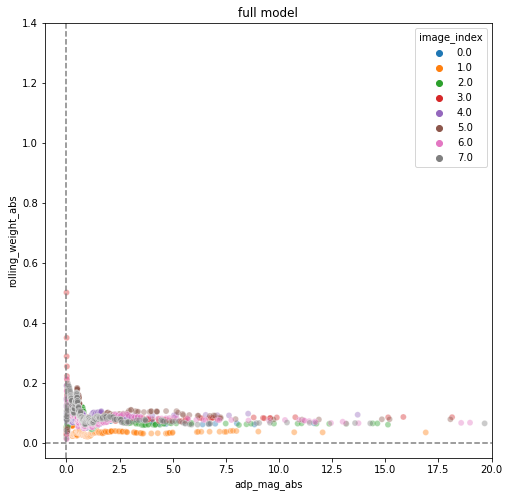

In [ ]:
# rolling absolute weight across absolute adp mag

def plot_weight_across_adp_abs_roll(weight, title_str):
  weight_vs_adp = np.array([adp_mag.flatten('F'), weight.flatten('F'), image_index.flatten('F')]).T
  df = pd.DataFrame(weight_vs_adp, columns=["adp_mag", "weight", "image_index"])
  df['adp_mag_abs'] = df['adp_mag'].abs()
  df['weight_abs'] = df['weight'].abs()

  df_whole = pd.DataFrame()
  for i in np.arange(8):
    df_img = df[df.image_index == i].sort_values(by=['adp_mag_abs'], ascending=True).copy()
    df_img['rolling_weight_abs'] = np.abs(df_img['weight_abs'].rolling(50, min_periods=1).mean())
    df_whole = pd.concat([df_whole,df_img])

  df_whole['image_index'] = df_whole.image_index.astype('category')
  # f = plt.subplots(figsize=(8, 8))
  # f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
  f, (ax0) = plt.subplots(1,1, figsize=(8, 8), sharex=True, sharey=True)

  sns.scatterplot(data=df_whole, x="adp_mag_abs", y="rolling_weight_abs", hue="image_index", alpha=0.4, ax=ax0)
  # sns.scatterplot(data=df_whole, x="adp_mag_abs", y="weight_abs", hue="image_index", alpha=0.4, ax=ax1)
  plt.xlim(-1,20);
  # plt.xlim(-0.1,5);
  plt.ylim(-0.05,1.4);
  # plt.ylim(-0.05,8);
  plt.title(title_str)
  ax0.axhline(y=0, linestyle='--', color='grey'); ax0.axvline(x=0, linestyle='--', color='grey');
  # ax1.axhline(y=0, linestyle='--', color='grey'); ax1.axvline(x=0, linestyle='--', color='grey');
  
  return df_whole

df_whole_un = plot_weight_across_adp_abs_roll(un_weight, "unadapted model")
df_whole_ad = plot_weight_across_adp_abs_roll(ad_weight, "adapted model")
df_whole_full = plot_weight_across_adp_abs_roll(full_weight, "full model")

### hist of abs? KDE?

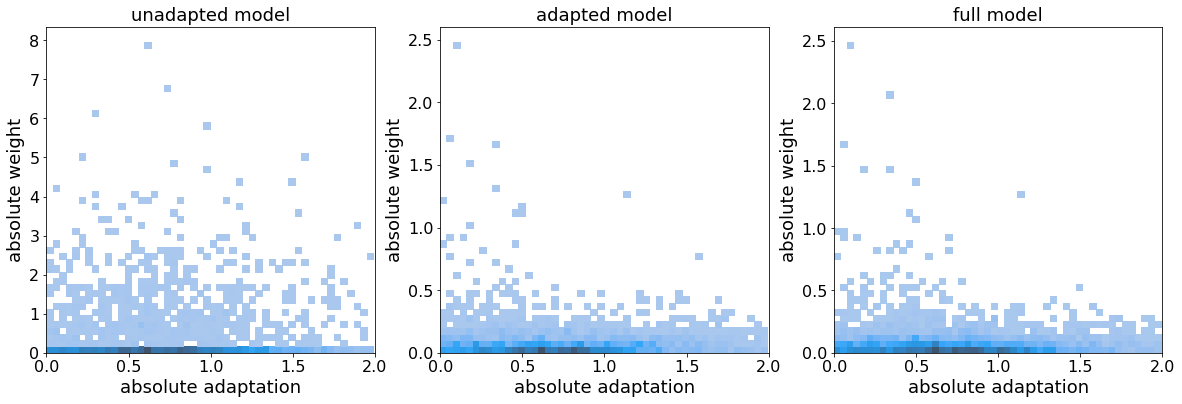

In [ ]:
def plot_weight_across_adp_abs(df, title_str, ax_n):

  df_abs = df.copy() # .drop(columns="rolling_weight")
  df_abs["adp_mag_abs"] = np.abs(df_abs.adp_mag)
  df_abs["weight_abs"] = np.abs(df_abs.weight)

  # plt.subplots(figsize=(11, 9))
  # ax = plt.gca(); 
  ax = ax_n
  sns.histplot(data=df_abs[df_abs.adp_mag_abs<=2], x="adp_mag_abs", y="weight_abs", bins=50, kde=True, ax=ax_n) #, hue="image_index"
  # sns.histplot(data=df_abs, x="adp_mag_abs", y="weight_abs", bins=20, kde=True, ax=ax_n) #, hue="image_index"
  ax.grid(False)
  ax.set_xlim(0,2)
  # ax.set_xlim(0,20)
  # ax.set_xticks(np.arange(0,20.1,2))
  ax.tick_params(axis="x", labelsize=16)
  ax.tick_params(axis="y", labelsize=16)
  ax.set_ylim(bottom=0)
  # ax.set_ylim(0,8);
  # ax.set_ylim(0,2.5);
  
  ax.set_xlabel('absolute adaptation', fontsize=18)
  ax.set_ylabel('absolute weight', fontsize=18)
  ax.set_title(title_str, fontsize=18)
  # ax.axvline(x=0, linewidth=2, color='grey', linestyle="--")
  # ax.axvline(x=1, linewidth=2, color='grey', linestyle="--")

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6), sharex=True, sharey=False)
plot_weight_across_adp_abs(df_whole_un, "unadapted model", ax1)
plot_weight_across_adp_abs(df_whole_ad, "adapted model", ax2)
plot_weight_across_adp_abs(df_whole_full, "full model", ax3)

figtitle = 'Cells robust against adaptation contribute more to decoding';
# plt.suptitle(figtitle, fontsize=16, y=0.99);
# plt.tight_layout()

f.savefig(figtitle + '.pdf', format='pdf')
from google.colab import files
# files.download(figtitle + '.pdf')

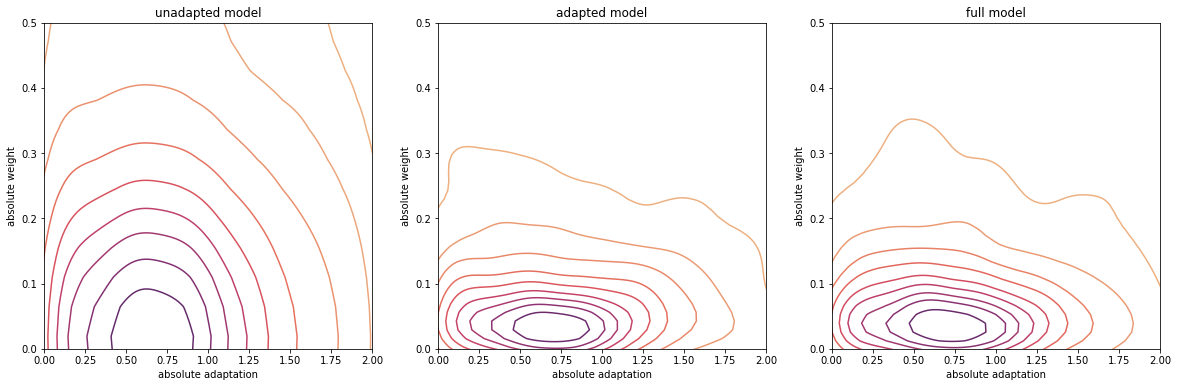

In [ ]:
def contour_weight_across_adp_abs(df, title_str, ax_n):

  df_abs = df.copy() # .drop(columns="rolling_weight")
  df_abs["adp_mag_abs"] = np.abs(df_abs.adp_mag)
  df_abs["weight_abs"] = np.abs(df_abs.weight)

  # plt.subplots(figsize=(11, 9))
  # ax = plt.gca(); 
  ax = ax_n
  # sns.histplot(data=df_abs[df_abs.adp_mag_abs<=2], x="adp_mag_abs", y="weight_abs", bins=50, kde=True, ax=ax_n) #, hue="image_index"
  sns.kdeplot(data=df_abs[df_abs.adp_mag_abs<=2], x="adp_mag_abs", y="weight_abs", ax=ax_n, cmap="flare")
  ax.grid(False)
  ax.set_xlim(0,2)
  # ax.set_xlim(0,20); ax.set_xticks(np.arange(0,20.1,2))
  ax.set_ylim(bottom=0)
  # ax.set_ylim(0,8);
  # ax.set_ylim(0,2.5);
  # ax.set_ylim(0,3.5);
  ax.set_ylim(0,0.5);
  
  ax.set_xlabel('absolute adaptation')
  ax.set_ylabel('absolute weight') #, fontsize=40
  ax.set_title(title_str)
  # ax.axvline(x=0, linewidth=2, color='grey', linestyle="--")
  # ax.axvline(x=1, linewidth=2, color='grey', linestyle="--")

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6), sharex=True, sharey=False)
contour_weight_across_adp_abs(df_whole_un, "unadapted model", ax1)
contour_weight_across_adp_abs(df_whole_ad, "adapted model", ax2)
contour_weight_across_adp_abs(df_whole_full, "full model", ax3)

figtitle = 'Cells robust against adaptation contribute more to decoding';
# plt.suptitle(figtitle, fontsize=16, y=0.99);
# plt.tight_layout()

# f.savefig(figtitle + '.pdf', format='pdf')
# from google.colab import files
# files.download(figtitle + '.pdf')

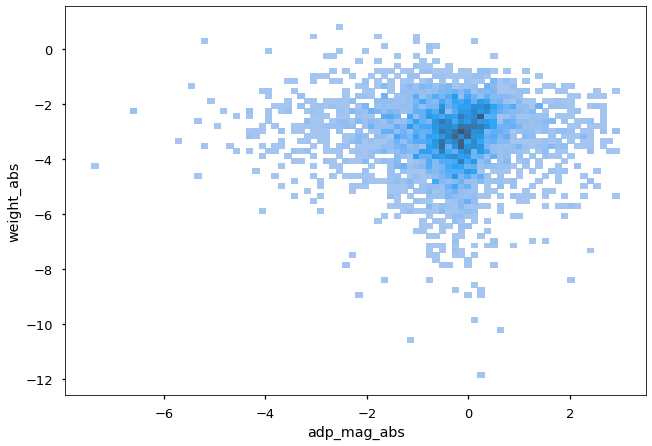

In [ ]:
sns.histplot(data=df_whole_ad, 
             x=np.log(df_whole_ad.adp_mag_abs), 
             y=np.log(df_whole_ad.weight_abs))
            #  bins=50, kde=True); #, hue="image_index"

## drop out analysis
dropping cells from input X (small to large weight / large to small variation via adaptation)  
retrain model (keep regularization constant)  
plot performance curve   
decrease in perf should be initially small, then sharp

In [ ]:
def dropout_test(model, data_part, drop_seq, control_or_sort):
  """
  model = clf.best_estimator_
  data_part = "full", "un", "ad"
  drop_seq = drop_seq_descend_weight, etc
  control_or_sort = 0 is control, 1 is sort
  """

  model.random_state = int(0)  
  drop_model = clone(model)

  if data_part == "full":
    X = full_X_n; y = full_y_n
  elif data_part == "un":
    X = unadapted_X_n; y = unadapted_y_n
  elif data_part == "ad":
    X = adapted_X_n; y = adapted_y_n

  if control_or_sort == 0:
    drop_seq = np.random.permutation(drop_seq)

  perf_mean = []; perf_std = []
  for idrop in np.arange(1, len(neuron_array)): # number of dropped cells: from 0 to ncell
    X_drop = X[neuron_array[drop_seq >= idrop]].values
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    acc_drop = []
    for train_index, test_index in skf.split(X_drop, y.image_index.values):
      X_train = X_drop[train_index]
      y_train = y.image_index.values[train_index]
      X_test = X_drop[test_index]
      y_test = y.image_index.values[test_index]
      
      drop_model.fit(X_train, y_train) # drop_model.score(X_test, y_test)
      y_pred = drop_model.predict(X_test)
      acc_fold = accuracy_score(y_test, y_pred)
      acc_drop.append(acc_fold)

    acc_drop_mean = np.mean(acc_drop); acc_drop_std = np.std(acc_drop)
    perf_mean.append(acc_drop_mean); perf_std.append(acc_drop_std)
    if np.mod(len(perf_mean), 100) == 0:
      print(len(perf_mean))
  
  return perf_mean, perf_std

In [ ]:
neuron_array = np.array(neuron_ids) # list to array

cell_weight = np.sum(full_weight, axis=1)
drop_seq = np.argsort(np.abs(cell_weight))
drop_seq_descend_weight = drop_seq[::-1] # large to small abs weight, most important cells first
drop_seq_ascend_weight = drop_seq

cell_adp = np.sum(adp_mag, axis=1)
drop_seq_ascend_adp = np.argsort(np.abs(cell_adp)) # small to large abs adp, most stable cells first
drop_seq_descend_adp = drop_seq_ascend_adp[::-1]

### all->all

In [ ]:
# perf_mean_full_sort_weight, perf_std_full_sort_weight = dropout_test(clf_full.best_estimator_, "full", drop_seq_descend_weight, 1) # large to small abs weight
# perf_mean_full_control_weight, perf_std_full_control_weight = dropout_test(clf_full.best_estimator_, "full", drop_seq_descend_weight, 0) # shuffle control
# perf_mean_full_rev_weight, perf_std_full_rev_weight = dropout_test(clf_full.best_estimator_, "full", drop_seq_ascend_weight, 1) # reverse

# perf_mean_full_sort_adp, perf_std_full_sort_adp = dropout_test(clf_full.best_estimator_, "full", drop_seq_ascend_adp, 1) # small to large adp
# perf_mean_full_control_adp, perf_std_full_control_adp = dropout_test(clf_full.best_estimator_, "full", drop_seq_ascend_adp, 0) # control
# perf_mean_full_rev_adp, perf_std_full_rev_adp = dropout_test(clf_full.best_estimator_, "full", drop_seq_descend_adp, 1) # reverse

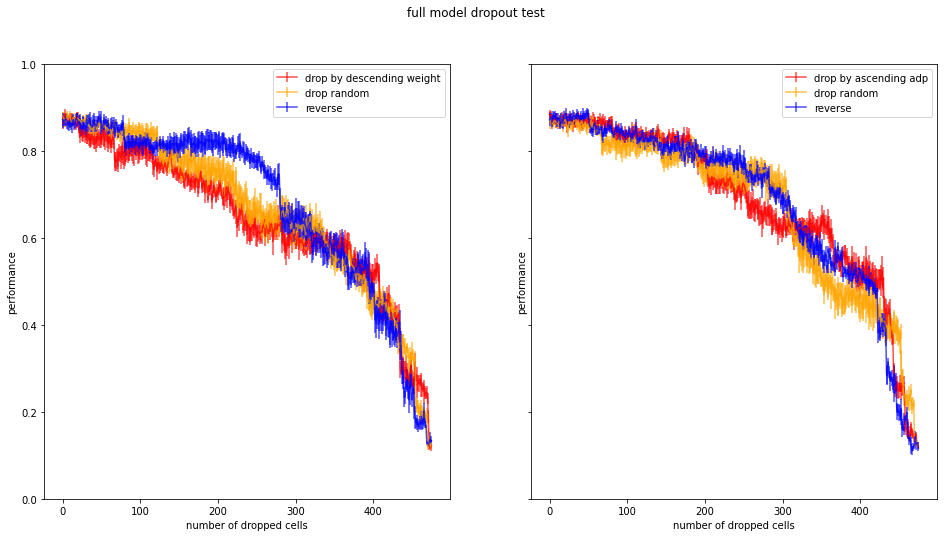

In [ ]:
# full model dropout test side by side (descending weight vs ascending adp)
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("full model dropout test")

x = np.arange(len(perf_mean_full_sort_weight))
perf_sem_full_sort_weight = perf_std_full_sort_weight / np.sqrt(5)
perf_sem_full_control_weight = perf_std_full_control_weight / np.sqrt(5)
perf_sem_full_rev_weight = perf_std_full_rev_weight / np.sqrt(5)

ax0.errorbar(x, perf_mean_full_sort_weight, perf_sem_full_sort_weight, color='red', alpha=0.7)
ax0.errorbar(x, perf_mean_full_control_weight, perf_sem_full_control_weight, color='orange', alpha=0.7)
ax0.errorbar(x, perf_mean_full_rev_weight, perf_sem_full_rev_weight, color='blue', alpha=0.7)
ax0.set_ylim(0,1)
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_full_sort_adp))
perf_sem_full_sort_adp = perf_std_full_sort_adp / np.sqrt(5)
perf_sem_full_control_adp = perf_std_full_control_adp / np.sqrt(5)
perf_sem_full_rev_adp = perf_std_full_rev_adp / np.sqrt(5)

ax1.errorbar(x, perf_mean_full_sort_adp, perf_sem_full_sort_adp, color='red', alpha=0.7)
ax1.errorbar(x, perf_mean_full_control_adp, perf_sem_full_control_adp, color='orange', alpha=0.7)
ax1.errorbar(x, perf_mean_full_rev_adp, perf_sem_full_rev_adp, color='blue', alpha=0.7)
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

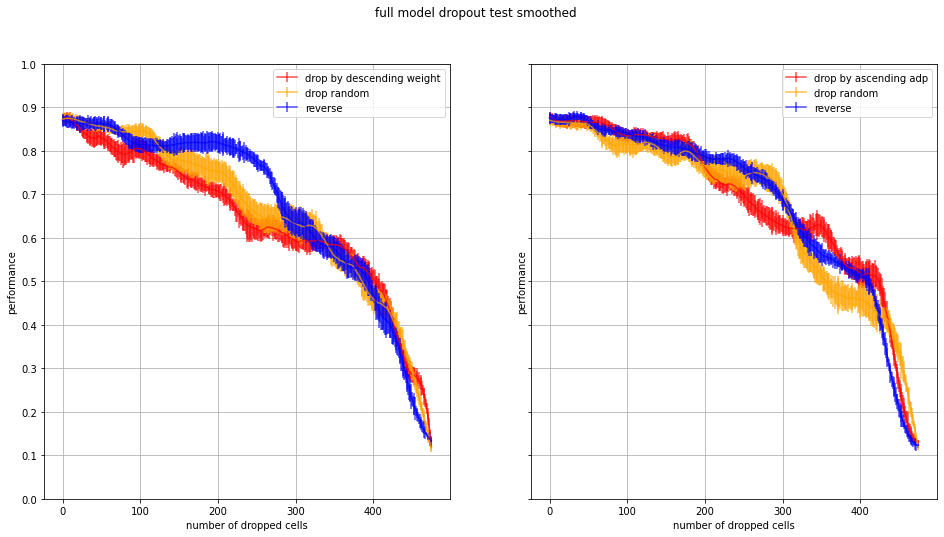

In [ ]:
# smooth ver
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("full model dropout test smoothed")

x = np.arange(len(perf_mean_full_sort_weight))
perf_sem_full_sort_weight = perf_std_full_sort_weight / np.sqrt(5)
perf_sem_full_control_weight = perf_std_full_control_weight / np.sqrt(5)
perf_sem_full_rev_weight = perf_std_full_rev_weight / np.sqrt(5)

win = 51; order = 3
ax0.errorbar(x, savgol_filter(perf_mean_full_sort_weight, win, order), perf_sem_full_sort_weight, color='red', alpha=0.7)
ax0.errorbar(x, savgol_filter(perf_mean_full_control_weight, win, order), perf_sem_full_control_weight, color='orange', alpha=0.7)
ax0.errorbar(x, savgol_filter(perf_mean_full_rev_weight, win, order), perf_sem_full_rev_weight, color='blue', alpha=0.7)
ax0.set_ylim(0,1)
ax0.set_yticks(np.arange(0,1.05,0.1))
ax0.grid(axis = 'both')
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_full_sort_adp))
perf_sem_full_sort_adp = perf_std_full_sort_adp / np.sqrt(5)
perf_sem_full_control_adp = perf_std_full_control_adp / np.sqrt(5)
perf_sem_full_rev_adp = perf_std_full_rev_adp / np.sqrt(5)

ax1.errorbar(x, savgol_filter(perf_mean_full_sort_adp, win, order), perf_sem_full_sort_adp, color='red', alpha=0.7)
ax1.errorbar(x, savgol_filter(perf_mean_full_control_adp, win, order), perf_sem_full_control_adp, color='orange', alpha=0.7)
ax1.errorbar(x, savgol_filter(perf_mean_full_rev_adp, win, order), perf_sem_full_rev_adp, color='blue', alpha=0.7)
ax1.set_yticks(np.arange(0,1.05,0.1))
ax1.grid(axis = 'both')
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

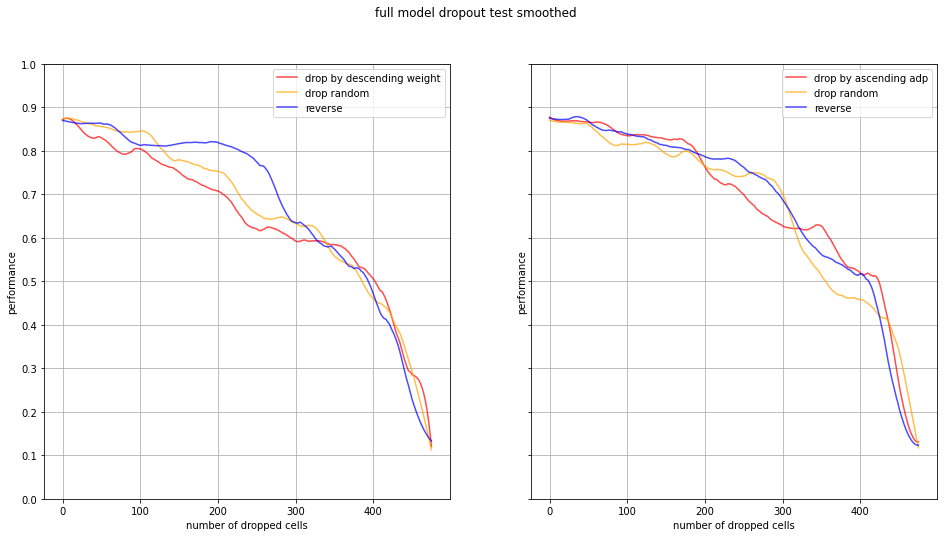

In [ ]:
# smooth line ver
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("full model dropout test smoothed")

x = np.arange(len(perf_mean_full_sort_weight))
perf_sem_full_sort_weight = perf_std_full_sort_weight / np.sqrt(5)
perf_sem_full_control_weight = perf_std_full_control_weight / np.sqrt(5)
perf_sem_full_rev_weight = perf_std_full_rev_weight / np.sqrt(5)

win = 51; order = 3
ax0.plot(x, savgol_filter(perf_mean_full_sort_weight, win, order), color='red', alpha=0.7)
ax0.plot(x, savgol_filter(perf_mean_full_control_weight, win, order), color='orange', alpha=0.7)
ax0.plot(x, savgol_filter(perf_mean_full_rev_weight, win, order), color='blue', alpha=0.7)
ax0.set_ylim(0,1)
ax0.set_yticks(np.arange(0,1.05,0.1))
ax0.grid(axis = 'both')
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_full_sort_adp))
perf_sem_full_sort_adp = perf_std_full_sort_adp / np.sqrt(5)
perf_sem_full_control_adp = perf_std_full_control_adp / np.sqrt(5)
perf_sem_full_rev_adp = perf_std_full_rev_adp / np.sqrt(5)

ax1.plot(x, savgol_filter(perf_mean_full_sort_adp, win, order), color='red', alpha=0.7)
ax1.plot(x, savgol_filter(perf_mean_full_control_adp, win, order), color='orange', alpha=0.7)
ax1.plot(x, savgol_filter(perf_mean_full_rev_adp, win, order), color='blue', alpha=0.7)
ax1.set_yticks(np.arange(0,1.05,0.1))
ax1.grid(axis = 'both')
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

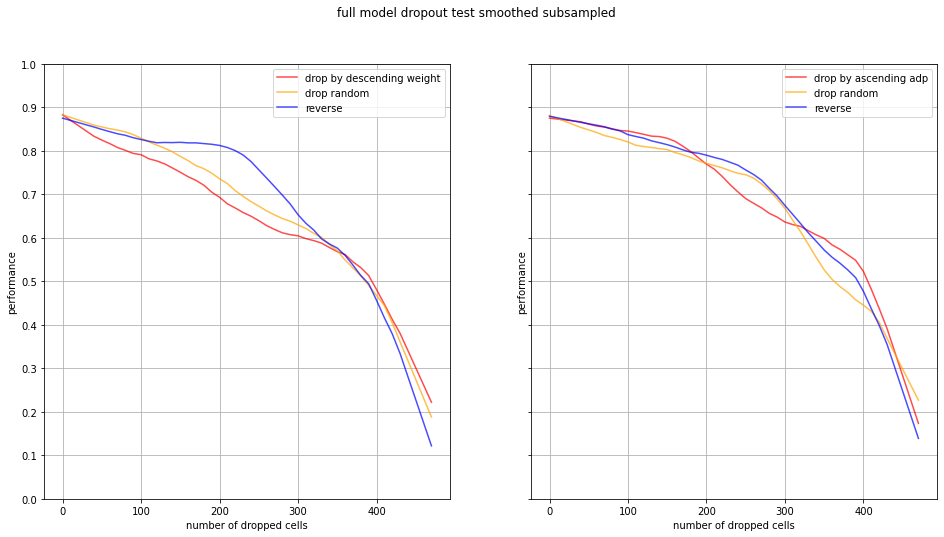

In [ ]:
# subsampling

# smooth ver
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("full model dropout test smoothed subsampled")

drop_step = 10
x = np.arange(len(perf_mean_full_sort_weight[::drop_step]))
win = 9; order = 1
ax0.plot(x, savgol_filter(perf_mean_full_sort_weight[::drop_step], win, order), color='red', alpha=0.7)
ax0.plot(x, savgol_filter(perf_mean_full_control_weight[::drop_step], win, order), color='orange', alpha=0.7)
ax0.plot(x, savgol_filter(perf_mean_full_rev_weight[::drop_step], win, order), color='blue', alpha=0.7)
ax0.set_ylim(0,1)
ax0.set_yticks(np.arange(0,1.05,0.1))
ax0.grid(axis = 'both')
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_full_sort_adp[::drop_step]))
ax1.plot(x, savgol_filter(perf_mean_full_sort_adp[::drop_step], win, order), color='red', alpha=0.7)
ax1.plot(x, savgol_filter(perf_mean_full_control_adp[::drop_step], win, order), color='orange', alpha=0.7)
ax1.plot(x, savgol_filter(perf_mean_full_rev_adp[::drop_step], win, order), color='blue', alpha=0.7)
ax1.set_yticks(np.arange(0,1.05,0.1))
ax1.set_xticklabels(np.arange(-100,401,100))
ax1.grid(axis = 'both')
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

### un->un

In [ ]:
# perf_mean_un_sort_weight, perf_std_un_sort_weight = dropout_test(clf_un.best_estimator_, "un", drop_seq_descend_weight, 1) # large to small abs weight
# perf_mean_un_control_weight, perf_std_un_control_weight = dropout_test(clf_un.best_estimator_, "un", drop_seq_descend_weight, 0) # shuffle control
# perf_mean_un_rev_weight, perf_std_un_rev_weight = dropout_test(clf_un.best_estimator_, "un", drop_seq_ascend_weight, 1) # reverse

# perf_mean_un_sort_adp, perf_std_un_sort_adp = dropout_test(clf_un.best_estimator_, "un", drop_seq_ascend_adp, 1) # small to large adp
# perf_mean_un_control_adp, perf_std_un_control_adp = dropout_test(clf_un.best_estimator_, "un", drop_seq_ascend_adp, 0) # control
# perf_mean_un_rev_adp, perf_std_un_rev_adp = dropout_test(clf_un.best_estimator_, "un", drop_seq_descend_adp, 1) # reverse

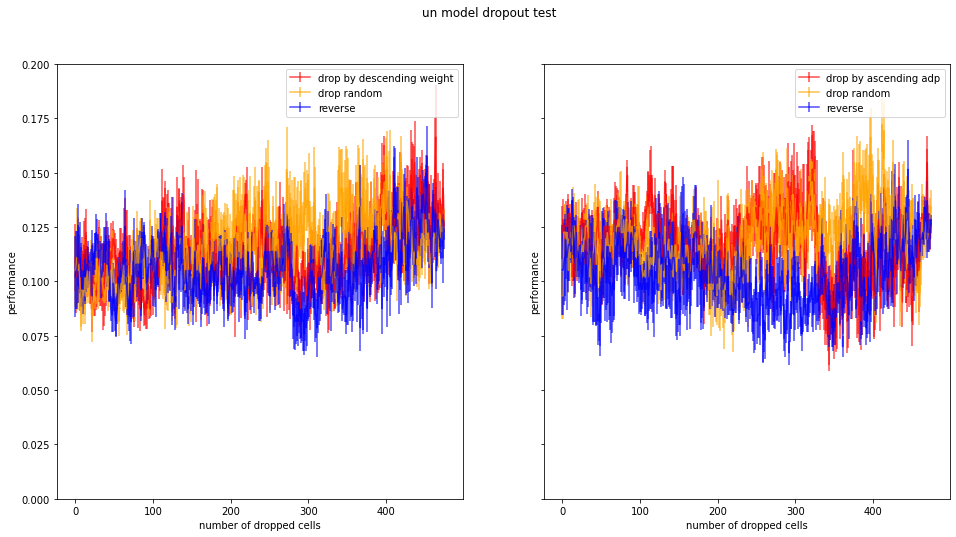

In [ ]:
# un model dropout test side by side (descending weight vs ascending adp)
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("un model dropout test") # , fontsize=14

x = np.arange(len(perf_mean_un_sort_weight))
perf_sem_un_sort_weight = perf_std_un_sort_weight / np.sqrt(5)
perf_sem_un_control_weight = perf_std_un_control_weight / np.sqrt(5)
perf_sem_un_rev_weight = perf_std_un_rev_weight / np.sqrt(5)

ax0.errorbar(x, perf_mean_un_sort_weight, perf_sem_un_sort_weight, color='red', alpha=0.7)
ax0.errorbar(x, perf_mean_un_control_weight, perf_sem_un_control_weight, color='orange', alpha=0.7)
ax0.errorbar(x, perf_mean_un_rev_weight, perf_sem_un_rev_weight, color='blue', alpha=0.7)
# ax0.set_ylim(0,1)
ax0.set_ylim(0,0.2)
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_un_sort_adp))
perf_sem_un_sort_adp = perf_std_un_sort_adp / np.sqrt(5)
perf_sem_un_control_adp = perf_std_un_control_adp / np.sqrt(5)
perf_sem_un_rev_adp = perf_std_un_rev_adp / np.sqrt(5)

ax1.errorbar(x, perf_mean_un_sort_adp, perf_sem_un_sort_adp, color='red', alpha=0.7)
ax1.errorbar(x, perf_mean_un_control_adp, perf_sem_un_control_adp, color='orange', alpha=0.7)
ax1.errorbar(x, perf_mean_un_rev_adp, perf_sem_un_rev_adp, color='blue', alpha=0.7)
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

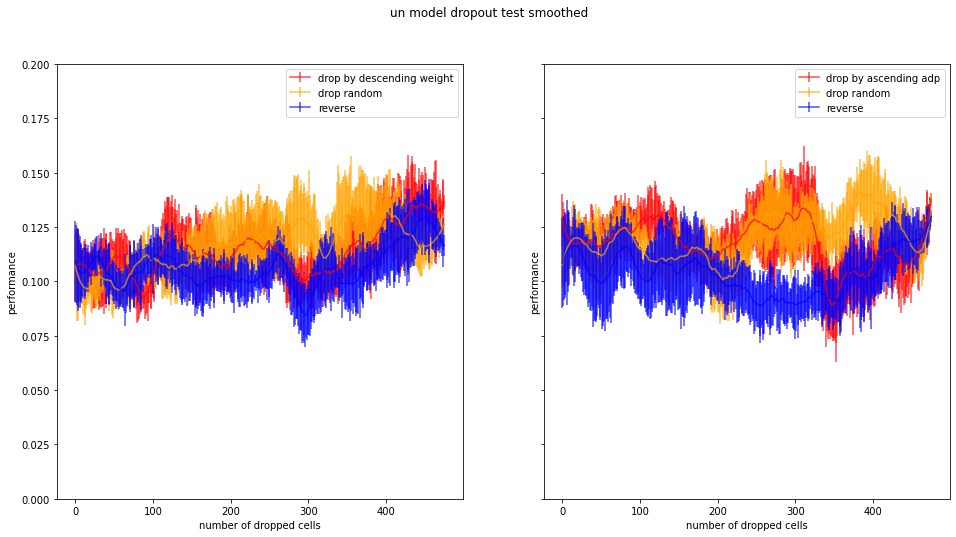

In [ ]:
# smooth ver
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("un model dropout test smoothed")

x = np.arange(len(perf_mean_un_sort_weight))
perf_sem_un_sort_weight = perf_std_un_sort_weight / np.sqrt(5)
perf_sem_un_control_weight = perf_std_un_control_weight / np.sqrt(5)
perf_sem_un_rev_weight = perf_std_un_rev_weight / np.sqrt(5)

win = 51; order = 3
ax0.errorbar(x, savgol_filter(perf_mean_un_sort_weight, win, order), perf_sem_un_sort_weight, color='red', alpha=0.7)
ax0.errorbar(x, savgol_filter(perf_mean_un_control_weight, win, order), perf_sem_un_control_weight, color='orange', alpha=0.7)
ax0.errorbar(x, savgol_filter(perf_mean_un_rev_weight, win, order), perf_sem_un_rev_weight, color='blue', alpha=0.7)
# ax0.set_ylim(0,1)
ax0.set_ylim(0,0.2)
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_un_sort_adp))
perf_sem_un_sort_adp = perf_std_un_sort_adp / np.sqrt(5)
perf_sem_un_control_adp = perf_std_un_control_adp / np.sqrt(5)
perf_sem_un_rev_adp = perf_std_un_rev_adp / np.sqrt(5)

ax1.errorbar(x, savgol_filter(perf_mean_un_sort_adp, win, order), perf_sem_un_sort_adp, color='red', alpha=0.7)
ax1.errorbar(x, savgol_filter(perf_mean_un_control_adp, win, order), perf_sem_un_control_adp, color='orange', alpha=0.7)
ax1.errorbar(x, savgol_filter(perf_mean_un_rev_adp, win, order), perf_sem_un_rev_adp, color='blue', alpha=0.7)
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

### ad->ad

In [ ]:
# perf_mean_ad_sort_weight, perf_std_ad_sort_weight = dropout_test(clf_ad.best_estimator_, "ad", drop_seq_descend_weight, 1) # large to small abs weight
# perf_mean_ad_control_weight, perf_std_ad_control_weight = dropout_test(clf_ad.best_estimator_, "ad", drop_seq_descend_weight, 0) # shuffle control
# perf_mean_ad_rev_weight, perf_std_ad_rev_weight = dropout_test(clf_ad.best_estimator_, "ad", drop_seq_ascend_weight, 1) # reverse

# perf_mean_ad_sort_adp, perf_std_ad_sort_adp = dropout_test(clf_ad.best_estimator_, "ad", drop_seq_ascend_adp, 1) # small to large adp
# perf_mean_ad_control_adp, perf_std_ad_control_adp = dropout_test(clf_ad.best_estimator_, "ad", drop_seq_ascend_adp, 0) # control
# perf_mean_ad_rev_adp, perf_std_ad_rev_adp = dropout_test(clf_ad.best_estimator_, "ad", drop_seq_descend_adp, 1) # reverse

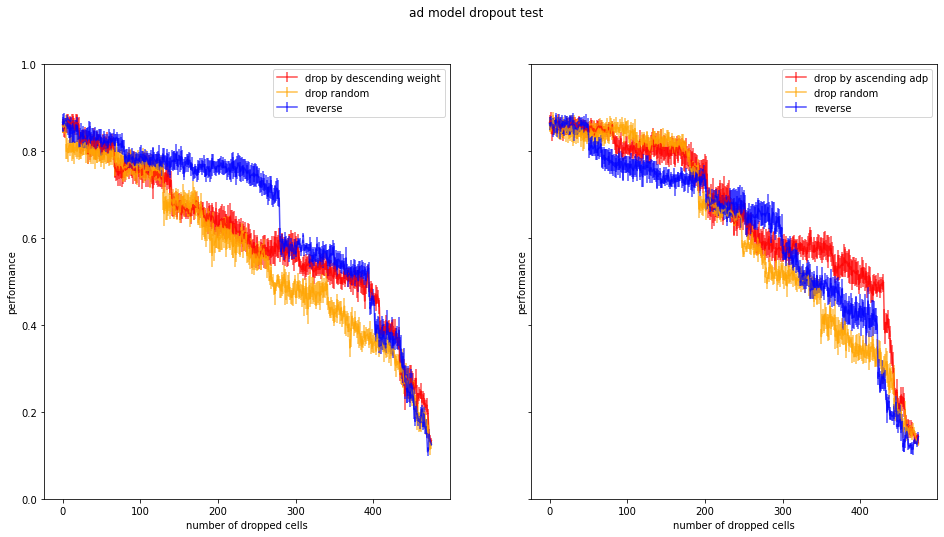

In [ ]:
# ad model dropout test side by side (descending weight vs ascending adp)
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("ad model dropout test")

x = np.arange(len(perf_mean_ad_sort_weight))
perf_sem_ad_sort_weight = perf_std_ad_sort_weight / np.sqrt(5)
perf_sem_ad_control_weight = perf_std_ad_control_weight / np.sqrt(5)
perf_sem_ad_rev_weight = perf_std_ad_rev_weight / np.sqrt(5)

ax0.errorbar(x, perf_mean_ad_sort_weight, perf_sem_ad_sort_weight, color='red', alpha=0.7)
ax0.errorbar(x, perf_mean_ad_control_weight, perf_sem_ad_control_weight, color='orange', alpha=0.7)
ax0.errorbar(x, perf_mean_ad_rev_weight, perf_sem_ad_rev_weight, color='blue', alpha=0.7)
ax0.set_ylim(0,1)
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_ad_sort_adp))
perf_sem_ad_sort_adp = perf_std_ad_sort_adp / np.sqrt(5)
perf_sem_ad_control_adp = perf_std_ad_control_adp / np.sqrt(5)
perf_sem_ad_rev_adp = perf_std_ad_rev_adp / np.sqrt(5)

ax1.errorbar(x, perf_mean_ad_sort_adp, perf_sem_ad_sort_adp, color='red', alpha=0.7)
ax1.errorbar(x, perf_mean_ad_control_adp, perf_sem_ad_control_adp, color='orange', alpha=0.7)
ax1.errorbar(x, perf_mean_ad_rev_adp, perf_sem_ad_rev_adp, color='blue', alpha=0.7)
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

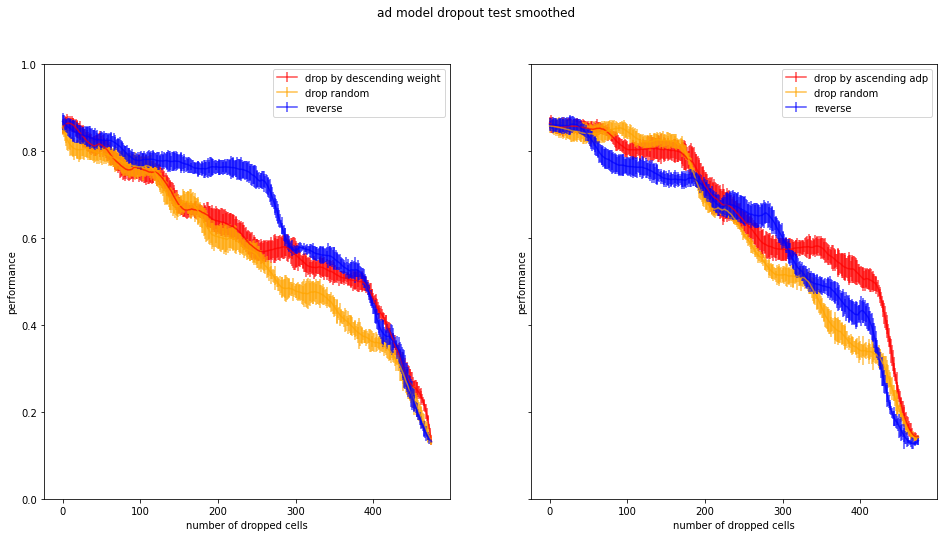

In [ ]:
# smooth ver
f, (ax0, ax1) = plt.subplots(1,2, figsize=(16, 8), sharex=True, sharey=True)
f.suptitle("ad model dropout test smoothed")

x = np.arange(len(perf_mean_ad_sort_weight))
perf_sem_ad_sort_weight = perf_std_ad_sort_weight / np.sqrt(5)
perf_sem_ad_control_weight = perf_std_ad_control_weight / np.sqrt(5)
perf_sem_ad_rev_weight = perf_std_ad_rev_weight / np.sqrt(5)

win = 51; order = 3
ax0.errorbar(x, savgol_filter(perf_mean_ad_sort_weight, win, order), perf_sem_ad_sort_weight, color='red', alpha=0.7)
ax0.errorbar(x, savgol_filter(perf_mean_ad_control_weight, win, order), perf_sem_ad_control_weight, color='orange', alpha=0.7)
ax0.errorbar(x, savgol_filter(perf_mean_ad_rev_weight, win, order), perf_sem_ad_rev_weight, color='blue', alpha=0.7)
ax0.set_ylim(0,1)
ax0.set_ylabel("performance")
ax0.set_xlabel("number of dropped cells")
ax0.legend(["drop by descending weight", "drop random", "reverse"])

x = np.arange(len(perf_mean_ad_sort_adp))
perf_sem_ad_sort_adp = perf_std_ad_sort_adp / np.sqrt(5)
perf_sem_ad_control_adp = perf_std_ad_control_adp / np.sqrt(5)
perf_sem_ad_rev_adp = perf_std_ad_rev_adp / np.sqrt(5)

ax1.errorbar(x, savgol_filter(perf_mean_ad_sort_adp, win, order), perf_sem_ad_sort_adp, color='red', alpha=0.7)
ax1.errorbar(x, savgol_filter(perf_mean_ad_control_adp, win, order), perf_sem_ad_control_adp, color='orange', alpha=0.7)
ax1.errorbar(x, savgol_filter(perf_mean_ad_rev_adp, win, order), perf_sem_ad_rev_adp, color='blue', alpha=0.7)
ax1.legend(["drop by ascending adp", "drop random", "reverse"])
ax1.set_ylabel("performance")
ax1.set_xlabel("number of dropped cells");

### save / load dropout result

In [ ]:
# import pickle
# file_name = 'dropout.pckl'
# f = open(file_name, 'wb')
# pickle.dump([perf_mean_full_sort_weight, perf_std_full_sort_weight,
#              perf_mean_full_control_weight, perf_std_full_control_weight,
#              perf_mean_full_rev_weight, perf_std_full_rev_weight,
#              perf_mean_full_sort_adp, perf_std_full_sort_adp,
#              perf_mean_full_control_adp, perf_std_full_control_adp,
#              perf_mean_full_rev_adp, perf_std_full_rev_adp,

#              perf_mean_un_sort_weight, perf_std_un_sort_weight,
#              perf_mean_un_control_weight, perf_std_un_control_weight,
#              perf_mean_un_rev_weight, perf_std_un_rev_weight,
#              perf_mean_un_sort_adp, perf_std_un_sort_adp,
#              perf_mean_un_control_adp, perf_std_un_control_adp,
#              perf_mean_un_rev_adp, perf_std_un_rev_adp,

#              perf_mean_ad_sort_weight, perf_std_ad_sort_weight,
#              perf_mean_ad_control_weight, perf_std_ad_control_weight,
#              perf_mean_ad_rev_weight, perf_std_ad_rev_weight,
#              perf_mean_ad_sort_adp, perf_std_ad_sort_adp,
#              perf_mean_ad_control_adp, perf_std_ad_control_adp,
#              perf_mean_ad_rev_adp, perf_std_ad_rev_adp], f)
# f.close()
# from google.colab import files
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/"
DATA_PATH = "/content/drive/MyDrive/"
file_name = 'dropout.pckl'

f = open(DATA_PATH + file_name,'rb')
[perf_mean_full_sort_weight, perf_std_full_sort_weight,
  perf_mean_full_control_weight, perf_std_full_control_weight,
  perf_mean_full_rev_weight, perf_std_full_rev_weight,
  perf_mean_full_sort_adp, perf_std_full_sort_adp,
  perf_mean_full_control_adp, perf_std_full_control_adp,
  perf_mean_full_rev_adp, perf_std_full_rev_adp,

  perf_mean_un_sort_weight, perf_std_un_sort_weight,
  perf_mean_un_control_weight, perf_std_un_control_weight,
  perf_mean_un_rev_weight, perf_std_un_rev_weight,
  perf_mean_un_sort_adp, perf_std_un_sort_adp,
  perf_mean_un_control_adp, perf_std_un_control_adp,
  perf_mean_un_rev_adp, perf_std_un_rev_adp,

  perf_mean_ad_sort_weight, perf_std_ad_sort_weight,
  perf_mean_ad_control_weight, perf_std_ad_control_weight,
  perf_mean_ad_rev_weight, perf_std_ad_rev_weight,
  perf_mean_ad_sort_adp, perf_std_ad_sort_adp,
  perf_mean_ad_control_adp, perf_std_ad_control_adp,
  perf_mean_ad_rev_adp, perf_std_ad_rev_adp] = pickle.load(f)
f.close()
len(perf_mean_ad_rev_adp)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


476

## response patterns are more separable post adaptation?
OR: sparseness increase after adaptation  
sort cells by response to image #1    
plot response pattern to image #2  
do this for: pre vs post adaptation, diff image pairs  
compare: pearson correlation of sorted cell response vector

# Sleep

In [ ]:
a=1
import time
time.sleep(3600*3)

In [ ]:
whos

Variable                          Type              Data/Info
-------------------------------------------------------------
ConvergenceWarning                type              <class 'sklearn.exceptions.ConvergenceWarning'>
DATA_PATH                         str               /content/drive/MyDrive/
ElasticNet                        ABCMeta           <class 'sklearn.linear_mo<...>nate_descent.ElasticNet'>
ElasticNetCV                      ABCMeta           <class 'sklearn.linear_mo<...>te_descent.ElasticNetCV'>
GridSearchCV                      ABCMeta           <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
Lasso                             ABCMeta           <class 'sklearn.linear_mo<...>oordinate_descent.Lasso'>
LeaveOneOut                       ABCMeta           <class 'sklearn.model_sel<...>tion._split.LeaveOneOut'>
LinearRegression                  ABCMeta           <class 'sklearn.linear_mo<...>._base.LinearRegression'>
LinearSVC                         type              